In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

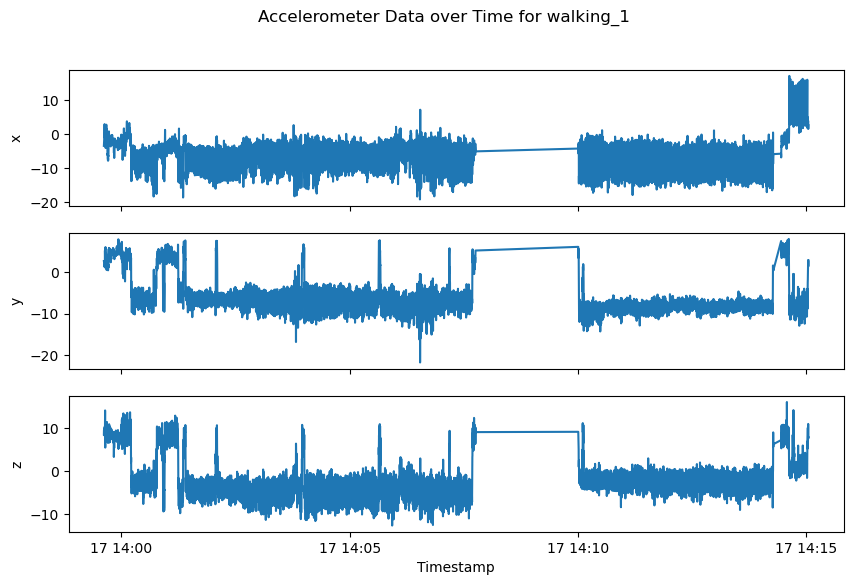

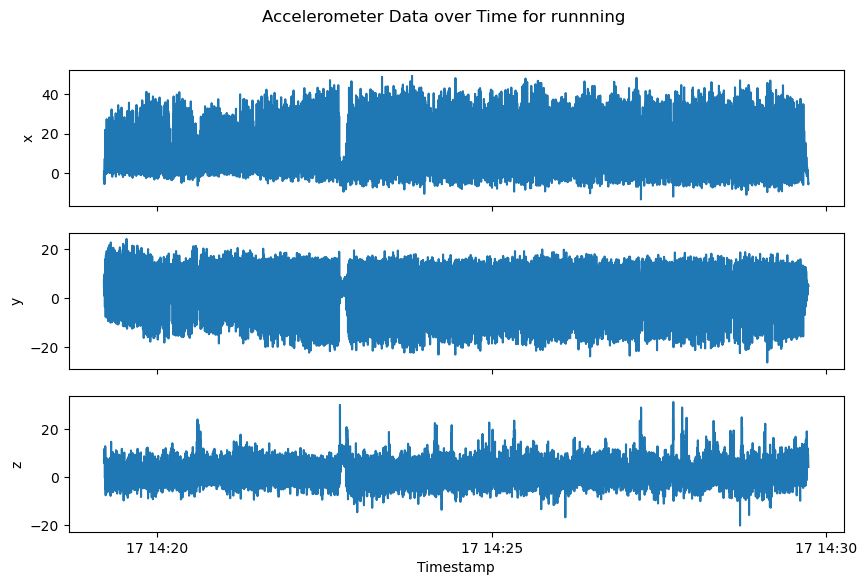

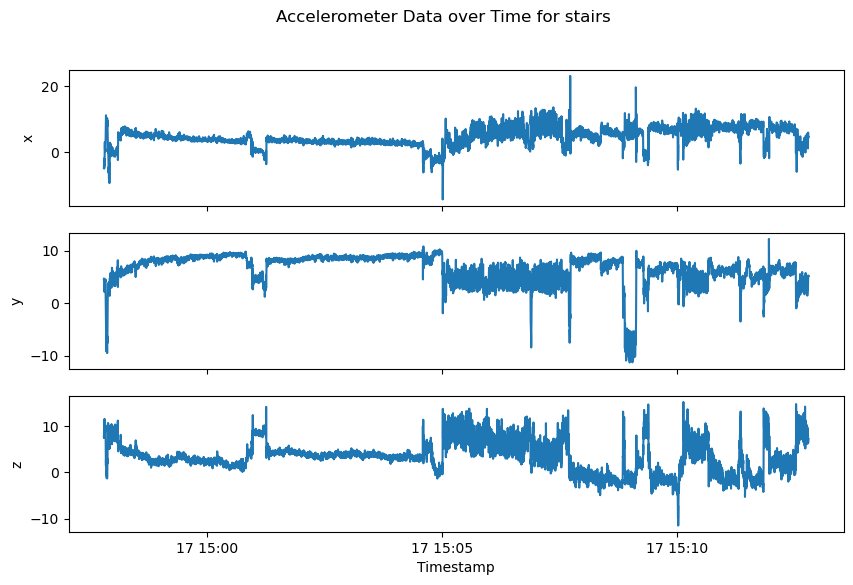

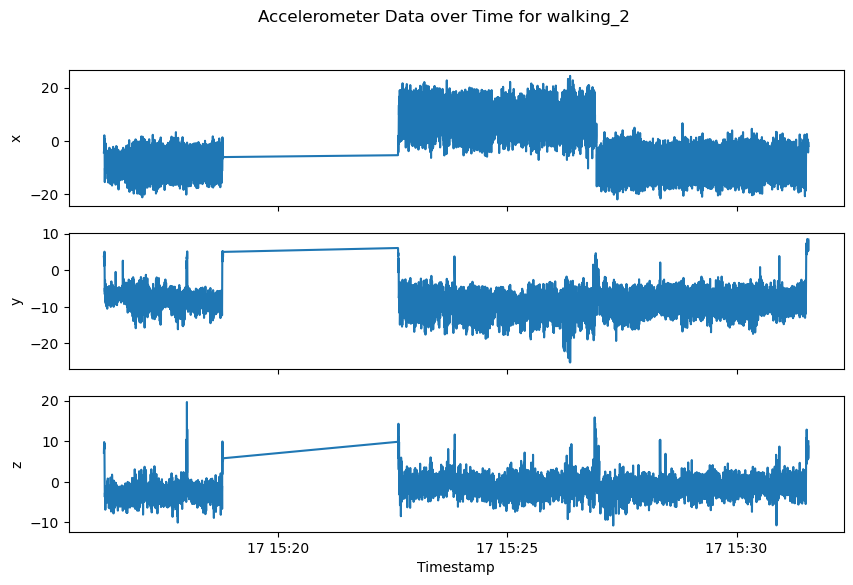

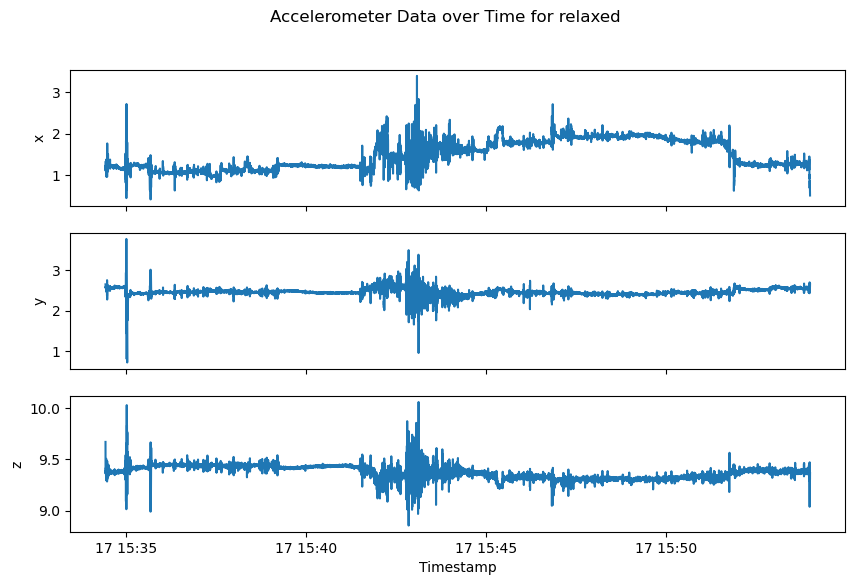

In [2]:
df = pd.read_csv('./data/final_data.csv')

# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Get the unique activities
activities = df['Source'].unique()

# For each activity
for activity in activities:
    activity_data = df[df['Source'] == activity]

    # Plot accelerometer data
    fig, axs = plt.subplots(3, sharex=True, figsize=(10, 6))
    fig.suptitle(f'Accelerometer Data over Time for {activity}')
    sns.lineplot(ax=axs[0], data=activity_data, x='Timestamp', y='Acceleration x (m/s^2)')
    axs[0].set_ylabel('x')
    sns.lineplot(ax=axs[1], data=activity_data, x='Timestamp', y='Acceleration y (m/s^2)')
    axs[1].set_ylabel('y')
    sns.lineplot(ax=axs[2], data=activity_data, x='Timestamp', y='Acceleration z (m/s^2)')
    axs[2].set_ylabel('z')
    plt.show()

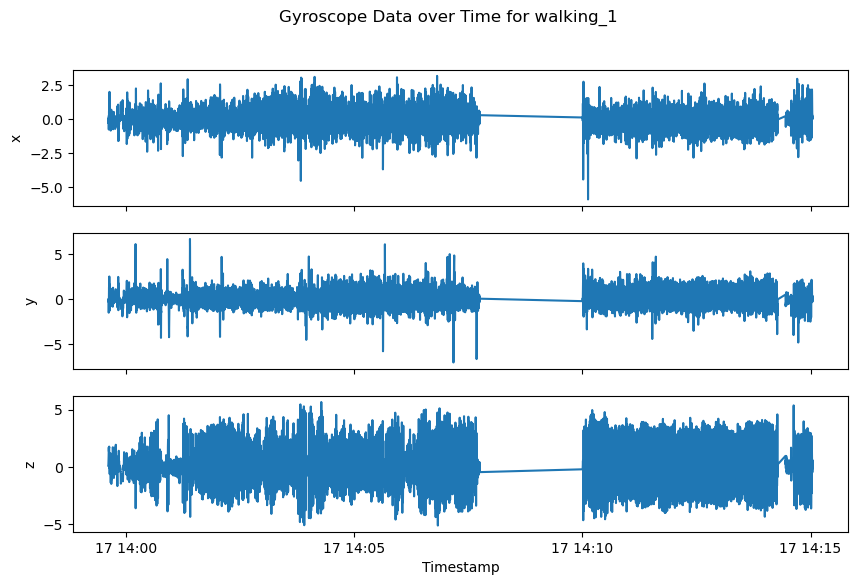

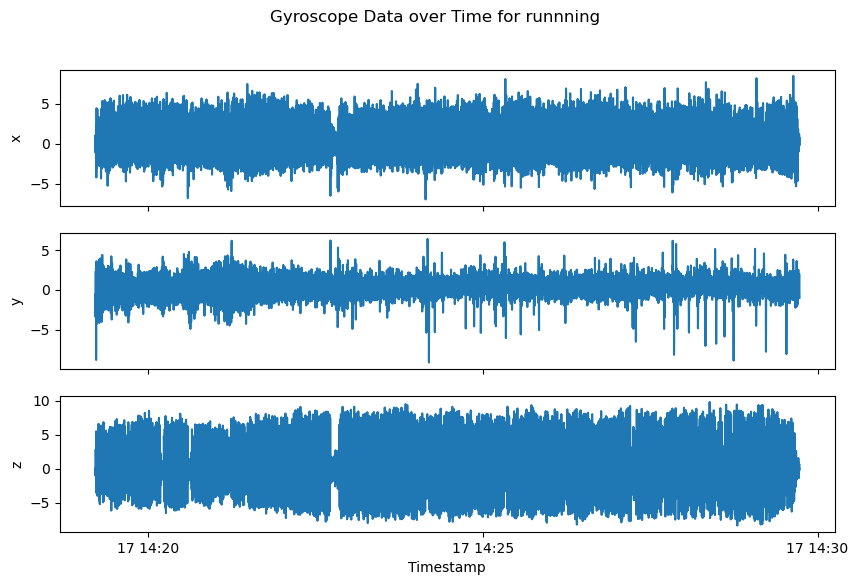

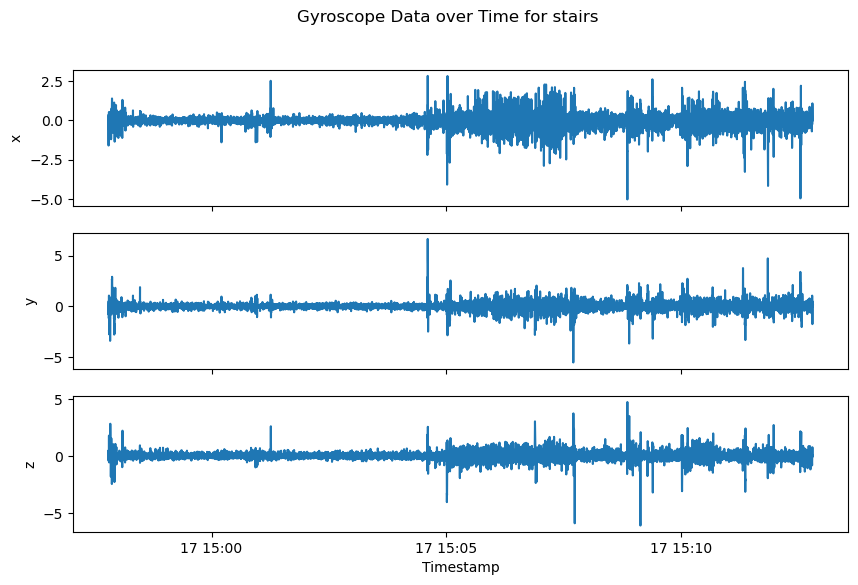

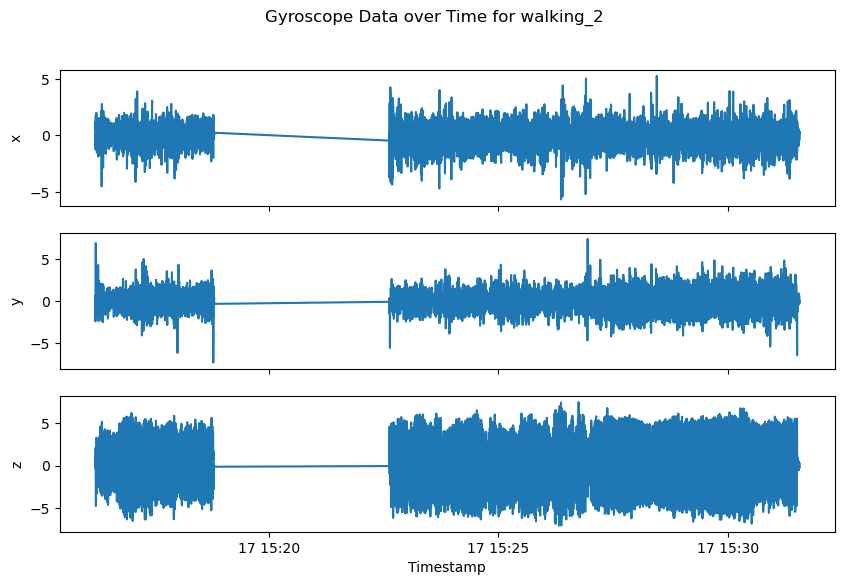

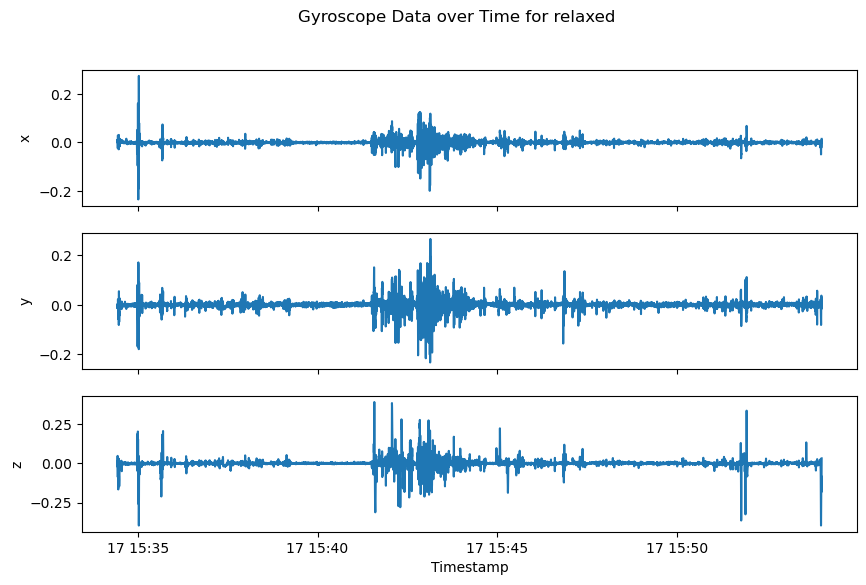

In [3]:
# For each activity
for activity in activities:
    activity_data = df[df['Source'] == activity]

    # Plot gyroscope data
    fig, axs = plt.subplots(3, sharex=True, figsize=(10, 6))
    fig.suptitle(f'Gyroscope Data over Time for {activity}')
    sns.lineplot(ax=axs[0], data=activity_data, x='Timestamp', y='Gyroscope x (rad/s)')
    axs[0].set_ylabel('x')
    sns.lineplot(ax=axs[1], data=activity_data, x='Timestamp', y='Gyroscope y (rad/s)')
    axs[1].set_ylabel('y')
    sns.lineplot(ax=axs[2], data=activity_data, x='Timestamp', y='Gyroscope z (rad/s)')
    axs[2].set_ylabel('z')
    plt.show()

C:\Users\liat1\AppData\Local\Temp\ipykernel_25020\3213164083.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_spent = df.groupby('Source').apply(lambda x: (x['Timestamp'].max() - x['Timestamp'].min()).total_seconds() / 60)


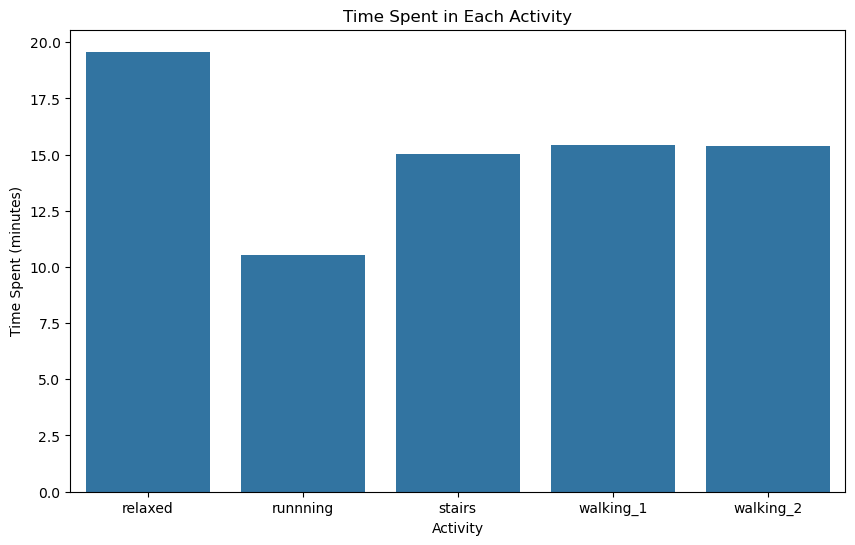

In [4]:
# Calculate the time spent in each activity
time_spent = df.groupby('Source').apply(lambda x: (x['Timestamp'].max() - x['Timestamp'].min()).total_seconds() / 60)

# Plot the time spent in each activity
plt.figure(figsize=(10, 6))
sns.barplot(x=time_spent.index, y=time_spent.values)
plt.title('Time Spent in Each Activity')
plt.xlabel('Activity')
plt.ylabel('Time Spent (minutes)')
plt.show()

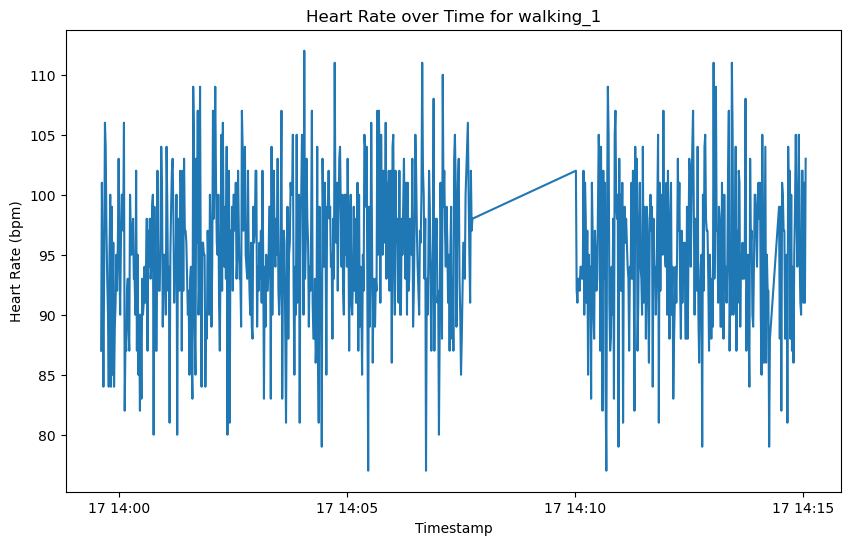

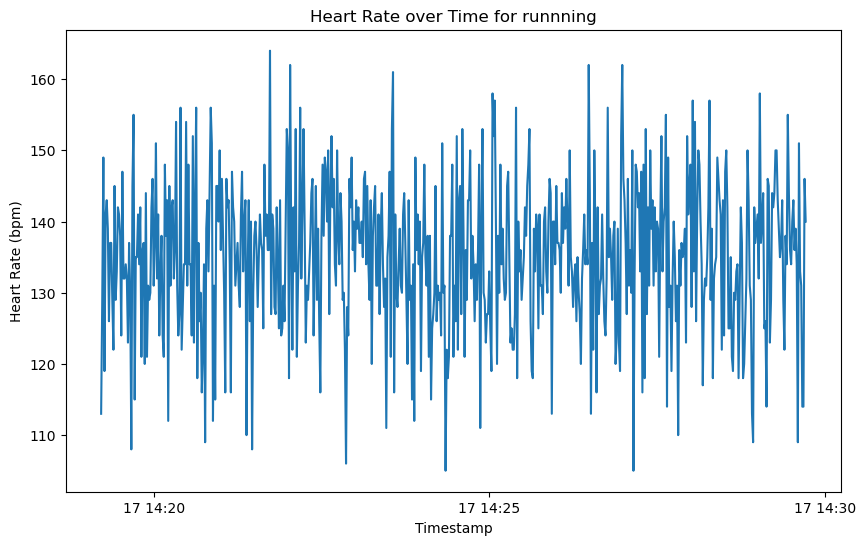

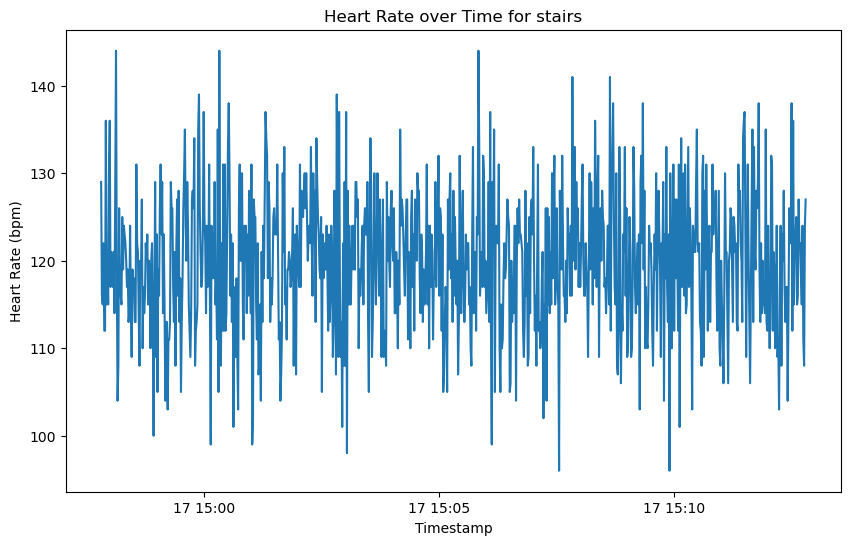

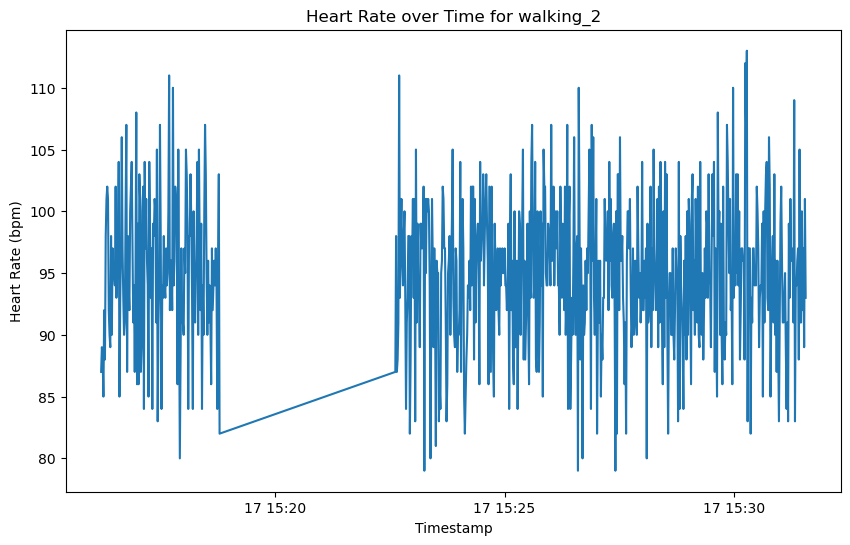

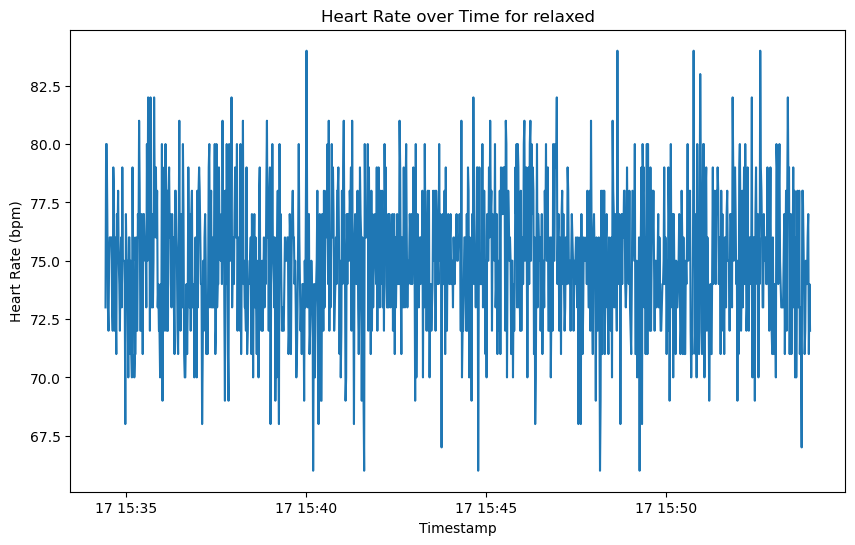

In [5]:
# For each activity
for activity in activities:
    activity_data = df[df['Source'] == activity]

    # Plot heart rate over time
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=activity_data, x='Timestamp', y='Heart Rate (bpm)')
    plt.title(f'Heart Rate over Time for {activity}')
    plt.show()

In [6]:
def print_variable_stats_by_activity(df):
    '''
    Function to print descriptive statistics for each numeric column
    for each category of activity, including total instances, mean,
    min, max, variance, median, standard deviation, and quartiles.

    Parameters:
    df: pandas dataframe
    '''
    activity_column = 'Activity'
    activities = df[activity_column].unique()
    
    for activity in activities:
        activity_df = df[df[activity_column] == activity]
        total_instances = activity_df.shape[0]
        
        print(f'Statistics for activity: {activity}')
        print('-' * 40)
        print(f'Total instances: {total_instances}')
        print('=' * 40)
        
        for column in activity_df.columns:
            if pd.api.types.is_numeric_dtype(activity_df[column]) and column != activity_column:
                mean = activity_df[column].mean()
                min_value = activity_df[column].min()
                max_value = activity_df[column].max()
                variance = activity_df[column].var()
                median = activity_df[column].median()
                missing_values = activity_df[column].isnull().sum()
                std = np.sqrt(variance)
                
                print(f'Statistics for column: {column}')
                print(f'Mean: {mean}')
                print(f'Min: {min_value}')
                print(f'Max: {max_value}')
                print(f'Standard Deviation: {std}')
                print(f'Median: {median}')
                print(f'Missing Values: {missing_values}')
                print('-' * 20)
        print('=' * 40)

In [7]:
print_variable_stats_by_activity(df)

Statistics for activity: walking_1
----------------------------------------
Statistics for column: Acceleration x (m/s^2)
Mean: -6.204443515414718
Min: -19.135417272
Max: 17.120217990999997
Variance: 20.03817447204323
--------------------
Statistics for column: Acceleration y (m/s^2)
Mean: -6.325198335349076
Min: -21.739351653
Max: 7.9815500735
Variance: 17.473959366994045
--------------------
Statistics for column: Acceleration z (m/s^2)
Mean: -2.1214808450911287
Min: -12.7579826362
Max: 16.197014235
Variance: 19.994456979356745
--------------------
Statistics for column: Gyroscope x (rad/s)
Mean: -0.05683228418062017
Min: -5.8931392670000005
Max: 3.1697186826
Variance: 0.6397629675258627
--------------------
Statistics for column: Gyroscope y (rad/s)
Mean: 0.023071228381791646
Min: -7.0050361634
Max: 6.637845039299999
Variance: 1.05858599186134
--------------------
Statistics for column: Gyroscope z (rad/s)
Mean: -0.01975304235175372
Min: -5.1186231375
Max: 5.6671190738
Variance: 4.2

In [8]:
def chauvenet_criterion(df, column, c=2, remove=False):
    '''
    Function to detect outliers based on Chauvenet's criterion
    
    Parameters:
    df: pandas dataframe
    column: string, name of the column to detect outliers
    c: float, constant for Chauvenet's criterion
    remove: boolean, whether to remove the outliers
    
    Returns:
    df: pandas dataframe with outliers marked or removed
    '''
    N = len(df)
    mean = df[column].mean()
    std = df[column].std()
    
    # Calculate the probability threshold
    threshold = 1 / (c * N)
    
    # Calculate the Z-scores
    df.loc[:, 'z_score'] = (df[column] - mean) / std
    
    # Calculate the cumulative distribution function (CDF) values
    df.loc[:, 'cdf'] = norm.cdf(df['z_score'])
    
    # Identify outliers based on Chauvenet's criterion
    df.loc[:, 'outlier'] = (df['cdf'] < threshold) | ((1 - df['cdf']) < threshold)
    
    # Count the number of outliers
    num_outliers = df['outlier'].sum()
    
    # Print the number of outliers and the top 5 outlier values
    if num_outliers > 0:
        print(f'Number of outliers in {column}: {num_outliers}')
        top_outliers = df[df['outlier']][column].sort_values(ascending=False).head(5)
        print(f'Top 5 outliers in {column}:')
        print(top_outliers)
        print('-' * 40)
    else:
        print(f'No outliers detected in {column}.')
        print('-' * 40)
    
    if remove:
        # Filter out the outliers
        df = df[~df['outlier']]
    
    # Drop the auxiliary columns
    df.drop(columns=['z_score', 'cdf', 'outlier'], inplace=True)
    
    return df

In [9]:
def analyze_outliers_by_activity(df, remove=False):
    '''
    Function to detect outliers based on Chauvenet's criterion
    for each numeric column within each activity, and optionally remove them
    
    Parameters:
    df: pandas dataframe
    remove: boolean, whether to remove the outliers
    
    Returns:
    df: pandas dataframe with outliers marked or removed
    '''
    activity_column = 'Source'
    activities = df[activity_column].unique()
    
    cleaned_df = pd.DataFrame()
    
    for activity in activities:
        activity_df = df[df[activity_column] == activity].copy()
        print(f'Processing activity: {activity}')
        print('=' * 40)
        for column in activity_df.columns:
            if pd.api.types.is_numeric_dtype(activity_df[column]) and column != activity_column:
                activity_df = chauvenet_criterion(activity_df, column, remove=remove)
        cleaned_df = pd.concat([cleaned_df, activity_df])
    
    return cleaned_df

In [10]:
# Analyze outliers by activity without removing them
analyze_outliers_by_activity(df, remove=False)
print("outliers detected")

Processing activity: walking_1


NameError: name 'norm' is not defined